In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import glob
import cv2
from albumentations import Rotate
from scipy import ndimage
import imutils
from skimage import data
from skimage import color
from skimage.filters import meijering, sato, frangi, hessian
from skimage.morphology import medial_axis, skeletonize, thin, remove_small_objects
import rdp
import math

In [5]:
def clean_image(img):
    """
    To delete name and centercrop
    """
    H,W = img.shape
    img = img[:W,...]
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

In [6]:
def crop_image(img):
    H,W = img.shape
    img = img[:W,...]
    img = img[W//4:W//4+W//2,W//4:W//4+W//2]
    return img

In [7]:
def crop_image_with_padding(img, w):
    H,W = img.shape
    img = img[:W,...]
    img = img[W//4-w//2:W//4+W//2+w//2,W//4-w//2:W//4+W//2+w//2]
    return img

In [8]:
def remove_boundary(img, w):
    H, W = img.shape
    img = img[w//2:-w//2+1,w//2:-w//2+1]
    return img

In [9]:
root_orig = 'FAZ_Tortuosity/Normal/'
root_mypoic = 'FAZ_Tortuosity/Myopia/'
root_marked = 'FAZ_Tortuosity/Vessel_marked/'

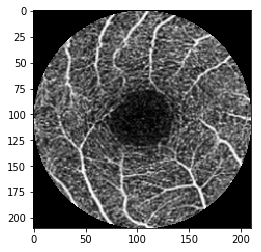

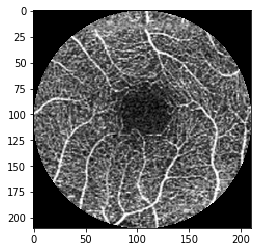

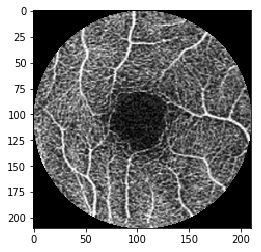

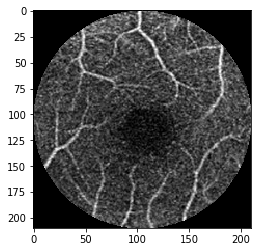

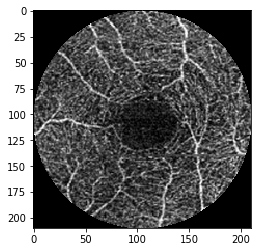

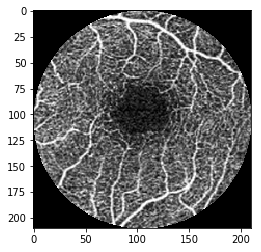

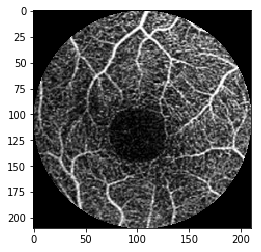

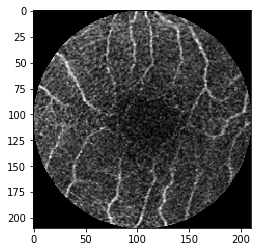

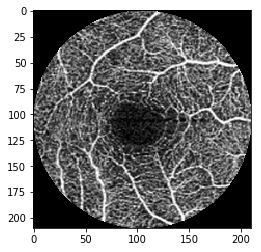

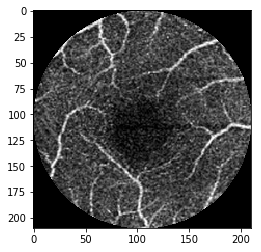

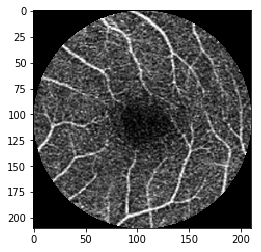

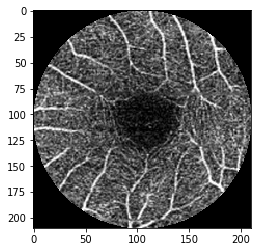

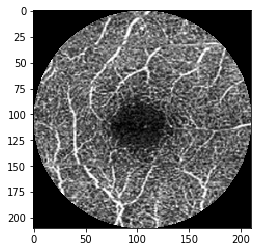

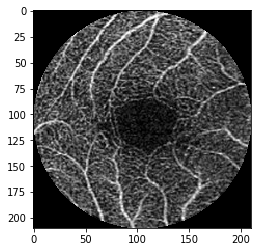

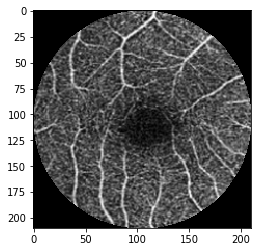

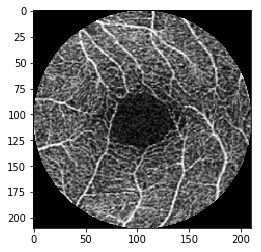

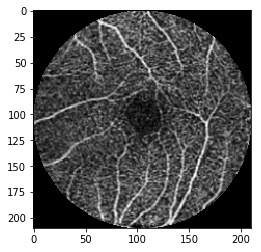

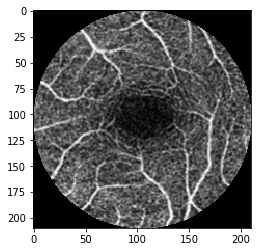

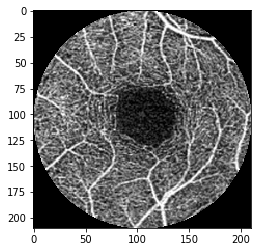

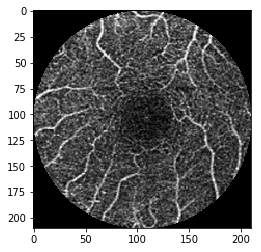

In [10]:
normals = glob.glob(root_orig+'*')[:11]
myopics = glob.glob(root_mypoic+'*')[:11]
paths = normals+myopics
for i, path in enumerate(paths):
    if i==9 or i==20:
        continue
    img = cv2.imread(path,0)
    img = clean_image(img)
    img = cv2.resize(img, (420, 420))
    img = crop_image(img)
    H, W = img.shape
    mask = np.zeros_like(img, np.uint8)
    mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
    img = img*(mask//255)
    cv2.imwrite('circular_cropped/'+path.split('/')[2], img)
    plt.imshow(img, cmap = 'gray')
    plt.show()

In [11]:
myopics

['FAZ_Tortuosity/Myopia/Sujatha_R__1204145_19950812_Female_Angiography 6x6 mm_20181001160620_OS_20190712164626 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/BANUPRIYA_R__1665278_19930623_Female_Angiography 6x6 mm_20190813132447_OS_20190814160939 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/RAMKUMAR_TD__2887588_19940812_Male_Angiography 6x6 mm_20190709104550_OD_20190709132405 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/MANPREET_KAUR__2887210_19880531_Female_Angiography 6x6 mm_20190627111240_OD_20190627114225 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/NAVEEN_MURALIDHARAN__2889767_19920903_Male_Angiography 6x6 mm_20190830125836_OD_20190904131232 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/MANPREET_KAUR__2887210_19880531_Female_Angiography 6x6 mm_20190627111433_OS_20190627114740 - Superficial.AngiographyEnface.jpg',
 'FAZ_Tortuosity/Myopia/KUMARI_MONIKA__3566619_19920813_Female_Angiography 6x6 mm_201907

In [12]:
def get_mask_img(marked_image, orig_img):
    H, W  = orig_img.shape
    marked_image = cv2.resize(marked_image,(W, H),interpolation = 2)
    image = (marked_image[...,0]==0)*(marked_image[...,1]==0)*(marked_image[...,2]==255).astype('uint8')*255
#     image = cv2.dilate(image, np.ones((3,3), dtype = np.uint8), iterations = 1)
    for i in range(0,H):
        if(np.unique(image[i,:]).shape[0]==2):
            u = i
            break
    for i in range(1,H):
        if(np.unique(image[H-i,:]).shape[0]==2):
            d = H-i
            break;
    for i in range(0,W):
        if(np.unique(image[:,i]).shape[0]==2):
            l = i
            break
    for i in range(1,W):
        if(np.unique(image[:,W-i]).shape[0]==2):
            r = W-i
            break
    print(u,d,l,r)
    marked_image = marked_image[u:d, l:r]
    seg = (marked_image[...,0]==255).astype('uint8')*255
    image = orig_img[u:d, l:r]
    mask = np.zeros_like(seg, np.uint8)
    H,W = image.shape
    mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
    masked_data = cv2.bitwise_and(seg, seg, mask=mask)
    image = image*(mask/255)
    return image, masked_data

In [13]:
# def get_mask_img(marked_image, orig_img):
#     H, W  = orig_img.shape
#     marked_image = cv2.resize(marked_image,(W, H),interpolation = 2)
#     image = (marked_image[...,0]==0)*(marked_image[...,1]==0)*(marked_image[...,2]==255).astype('uint8')*255
# #     image = cv2.dilate(image, np.ones((3,3), dtype = np.uint8), iterations = 1)
#     for i in range(0,H):
#         if(np.unique(image[i,:]).shape[0]==2):
#             u = i
#             break
#     for i in range(1,H):
#         if(np.unique(image[H-i,:]).shape[0]==2):
#             d = H-i
#             break;
#     for i in range(0,W):
#         if(np.unique(image[:,i]).shape[0]==2):
#             l = i
#             break
#     for i in range(1,W):
#         if(np.unique(image[:,W-i]).shape[0]==2):
#             r = W-i
#             break
# #     print(u,d,l,r)
#     marked_image = marked_image[u:d, l:r]
#     seg = (marked_image[...,0]==255).astype('uint8')*255
#     image = orig_img[u:d, l:r]
#     mask = np.zeros_like(seg, np.uint8)
#     H,W = image.shape
#     mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
#     masked_data = cv2.bitwise_and(seg, seg, mask=mask)
#     image = image*(mask/255)
#     return image, masked_data

94 321 97 323
255.0 255


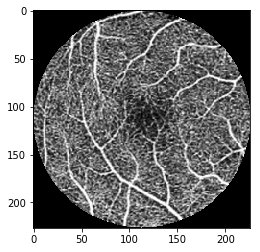

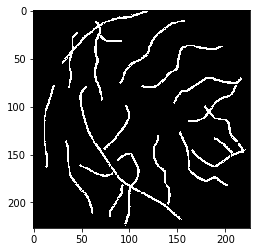

99 327 94 320
255.0 255


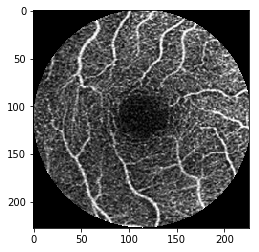

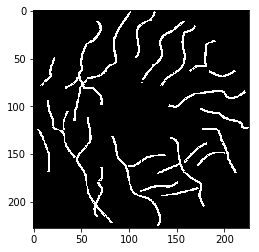

99 327 94 320
255.0 255


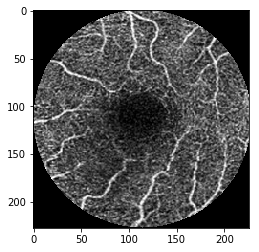

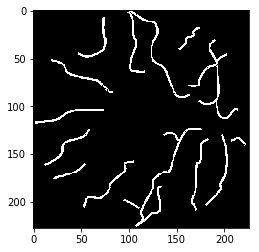

112 340 93 319
255.0 255


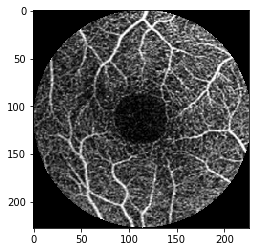

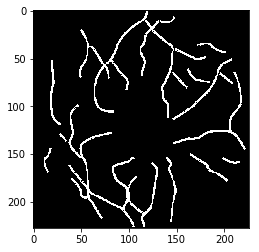

96 322 90 316
255.0 255


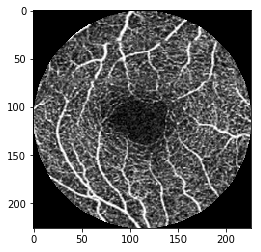

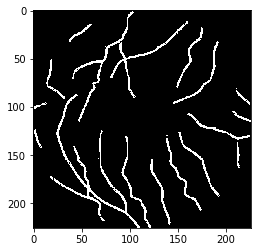

96 323 90 317
255.0 255


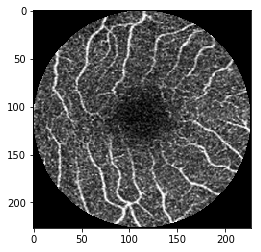

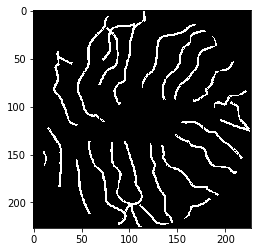

96 323 94 320
255.0 255


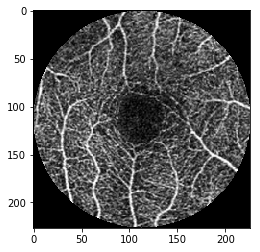

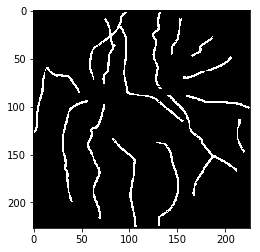

95 321 100 327
255.0 255


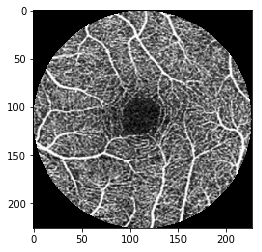

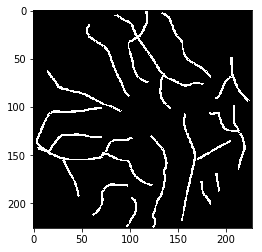

99 327 94 320
255.0 255


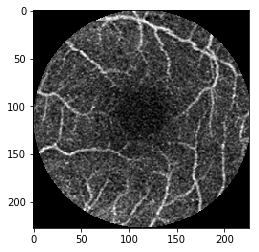

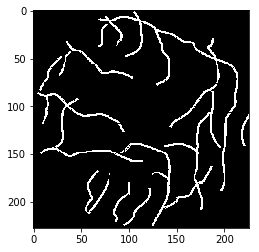

In [9]:
for i in range(df.shape[0]):
    orig_img = cv2.imread(root_orig+df['Actual File Ref No'].iloc[i], 0)
    if orig_img is None:
        orig_img = cv2.imread(root_orig+df['Actual File Ref No'].iloc[i]+'.jpg', 0)
    marked_img = cv2.imread(root_marked+'Pic'+df['File Name'].iloc[i].split(' ')[-1]+'.png')
    img, mask = get_mask_img(marked_img, orig_img)
    print(img.max(), mask.max())
    plt.imshow(img, cmap = 'gray')
    plt.show()
    plt.imshow(mask, cmap = 'gray')
    plt.show()
#     break

In [14]:
def get_line_arrays(w, l, angle):
    window = (np.ones((w,w))*0).astype('uint8')
    mid_point = w//2
    l = l//2
    if((angle<math.pi/4) or (angle>math.pi/2+math.pi/4)):
        start_point = (int(mid_point+l), int(mid_point-l*math.tan(angle)))
        end_point = (int(mid_point-l), int(mid_point+l*math.tan(angle)))
    elif(angle==math.pi/2):
        start_point = (mid_point, int(mid_point+l))
        end_point = (mid_point, int(mid_point-l))
    elif(angle==math.pi/4):
        start_point = (int(l+mid_point), int(mid_point+l))
        end_point = (int(-l+mid_point), int(mid_point-l))
    elif(angle==math.pi/2+math.pi/4):
        start_point = (int(-l+mid_point), int(mid_point+l))
        end_point = (int(l+mid_point), int(mid_point-l))
    else:
        start_point = (int(l/math.tan(angle)+mid_point), int(mid_point+l))
        end_point = (int(mid_point-l/math.tan(angle)), int(mid_point-l))
    color = 1
    thickness = 1
    window = cv2.line(window, start_point, end_point, color, thickness)
    return window
    
def lineseg(image, w, l):
    img = image.copy()
    H, W = img.shape
    
    for i in range(w//2, W-w//2):
        for j in range(w//2, H-w//2):
            window = img[i-w//2:i+w//2+1, j-w//2:j+w//2+1]
            line_responses = []
            for k in range(12):
                window_k = get_line_arrays(w, l, math.pi/12*k)
                line_response = np.sum(window_k*window)/np.sum(window_k)
                line_responses.append(line_response)
            img[i, j] = max(line_responses) - np.mean(window)
    return img

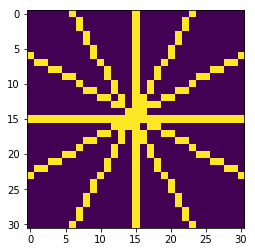

In [39]:
img = get_line_arrays(31, 31, math.pi/6*0)
for i in range(6):
    img += get_line_arrays(31,30, math.pi/6*i)
#     plt.imshow(img)
#     print(np.sum(img))
#     plt.show()
plt.imshow(img.clip(max = 1, min = 0))

In [16]:
# img_path = sorted(glob.glob('centered_imgs/*/*'))
img_path = sorted(glob.glob('FAZ_Tortuosity/*/*')) #Original Folder

In [17]:
img_orig = cv2.imread((img_path[1]))
def seg_img_multi(img, w_l = [(15, 3), (15, 7), (15, 11), (15, 15), (11, 3), (11, 7), (11, 11), (7, 3), (7,7), (3,3)]):
    temp = clean_image(img)
    img = np.zeros_like(crop_image(temp), dtype = float)
    for w_l_i in w_l:
        img += remove_boundary(lineseg(crop_image_with_padding(temp, w_l_i[0])/255, w_l_i[0], w_l_i[1]), w_l_i[0])
    return img/(len(w_l)+1)

In [22]:
img_seg = seg_img_multi(img_orig[...,0])

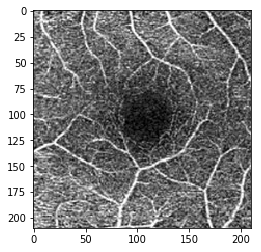

In [24]:
plt.imshow(crop_image(clean_image(img_orig[...,0])), cmap = 'gray')

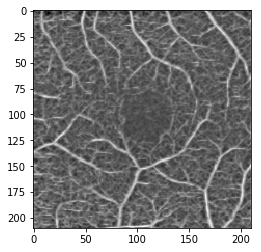

In [25]:
plt.imshow(img_seg, cmap = 'gray')

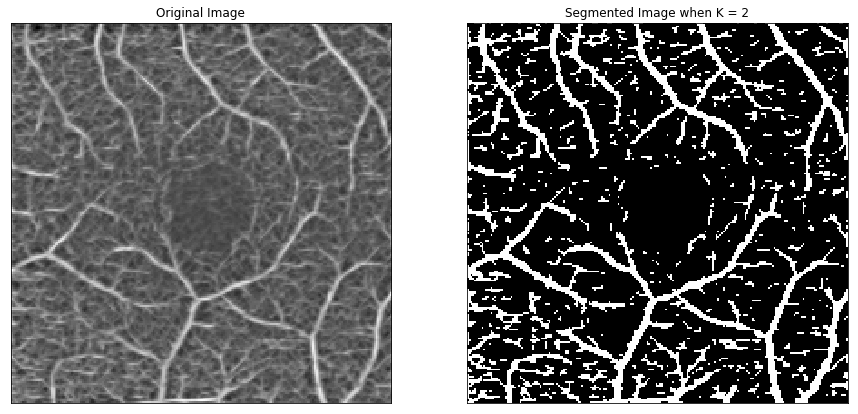

In [26]:
img = img_seg*255#clean_image(cv2.imread(img_path[1]))
# img = cv2.fastNlMeansDenoising(img,None,15,7,11) #mean denoising
vectorized = img.reshape((-1,1))
vectorized = np.float32(vectorized)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
criteria = (cv2.TERM_CRITERIA_MAX_ITER,20000, 0.0001)
K = 2
attempts=10
ret,label,center=cv2.kmeans(vectorized,K,None,criteria,attempts,cv2.KMEANS_RANDOM_CENTERS)
center = np.uint8(center)
res = center[label.flatten()]
result_image = res.reshape((img.shape))
# result_image = crop_image(result_image)
figure_size = 15
plt.figure(figsize=(figure_size,figure_size))
plt.subplot(1,2,1),plt.imshow(img, cmap = 'gray')
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(1,2,2),plt.imshow((result_image), cmap = 'gray')
plt.title('Segmented Image when K = %i' % K), plt.xticks([]), plt.yticks([])
plt.show()

In [421]:
result_image

array([[11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       [11, 11, 11, ..., 11, 11, 11],
       ...,
       [40, 40, 40, ..., 11, 11, 11],
       [11, 40, 40, ..., 11, 11, 11],
       [40, 40, 40, ..., 11, 11, 11]], dtype=uint8)

In [425]:
image = ((result_image)>=40).astype('uint8')*255
kernel = np.ones((2,2))
# image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected 
# image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
image = remove_small_objects(image.astype(bool), min_size=64, connectivity=0).astype(float)

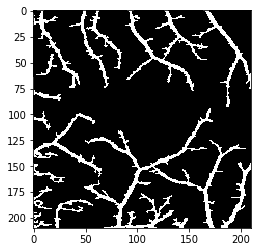

In [426]:
plt.imshow(image, cmap = 'gray')

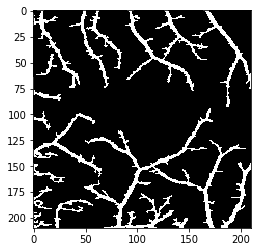

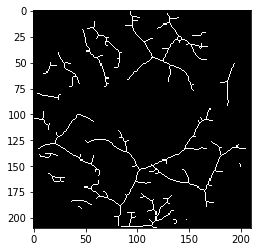

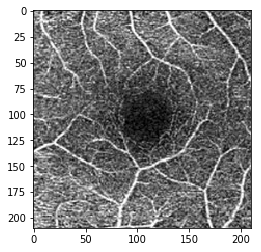

In [429]:
# image = crop_image(image)
# img_orig = clean_image(plt.imread(img_path[1])) 
# kernel = np.ones((2,2),np.uint8) #kernel for erosion and dilation

# img_denoise = cv2.fastNlMeansDenoising(img_orig,None,39,7,21) #mean denoising

# image = (hessian(image,)).astype('uint8') #ridge detection
# image = contrast_stretched
# image =  cv2.dilate(image,kernel,iterations = 1) #to join disconnected before removing small noise

# image = remove_small_objects(image.astype(bool), min_size=64, connectivity=0).astype(float)

# image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected 
# image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
# image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected
# image = cv2.erode(image,kernel,iterations = 1)  #to join disconnected
# image = cv2.dilate(image,kernel,iterations = 1) #to join disconnected

#Use any one below
skel = skeletonize(image)
# skel = thin(image)
# med, distance = medial_axis(image, return_distance=True)
# # skel = med*distance

#To get the circular part
mask = np.zeros_like(image, np.uint8)
H,W = image.shape
mask = cv2.circle(mask, (H//2,W//2), H//2, (255,255,255),thickness=-1)
masked_data = cv2.bitwise_and(skel*255, skel*255, mask=mask)

plt.imshow(image,cmap ='gray')
plt.show()
plt.imshow(masked_data,cmap ='gray')
plt.show()
plt.imshow(crop_image(clean_image(img_orig)),cmap ='gray')
plt.show()

# Working with segmented images

In [97]:
def get_points(skeleton_image):
    cnts = cv2.findContours(skeleton_image.copy().astype('uint8'), cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    return cnts

In [98]:
# FINAL:

In [99]:
def num_to_str(contour):
    str_list = list()
    for c in contour:
        str_list.append(str(c[0][0])+','+str(c[0][1]))
    return str_list

def get_unique(contour):
    cont = contour.copy()
    str_list = num_to_str(cont)
    index_dict = dict()
    for i in range(len(str_list)):
        if str_list[i] not in index_dict.keys():
            index_dict[str_list[i]] = i
    new_dict = dict((val,key) for key,val in index_dict.items())
    sub_cont = list()
    keys = list(new_dict.keys())
    keys.sort()
    sub_cont.append(list())
    last_ind = 0
    sub_cont[last_ind].append(new_dict[keys[0]])
    for i in range(len(keys)-1):
        if keys[i+1]-keys[i]!=1:
            last_ind+=1
            sub_cont.append(list())
            sub_cont[last_ind].append(new_dict[keys[i+1]])
        else:
            sub_cont[last_ind].append(new_dict[keys[i+1]])
    num_cont = sub_cont.copy()
    for l in range(len(num_cont)):
        for s in range(len(num_cont[l])):
            nums = num_cont[l][s].split(',')
            x = int(nums[0])
            y = int(nums[1])
            num_cont[l][s] = [x,y]
    return num_cont

# Turning Point

In [100]:
def angle(dir):
    """
    Returns the angles between vectors.

    Parameters:
    dir is a 2D-array of shape (N,M) representing N vectors in M-dimensional space.

    The return value is a 1D-array of values of shape (N-1,), with each value
    between 0 and pi.

    0 implies the vectors point in the same direction
    pi/2 implies the vectors are orthogonal
    pi implies the vectors point in opposite directions
    """
    dir2 = dir[1:]
    dir1 = dir[:-1]
    return np.arccos((dir1*dir2).sum(axis=1)/(
        np.sqrt((dir1**2).sum(axis=1)*(dir2**2).sum(axis=1))))

def get_turning_points_contour(contour, tolerance, min_angle):
    points = np.array(contour)
    simplified = np.array(rdp.rdp(points.tolist(), tolerance))
    sx, sy = simplified.T
    # compute the direction vectors on the simplified curve
    directions = np.diff(simplified, axis=0)
    theta = angle(directions)
    # Select the index of the points with the greatest theta
    # Large theta is associated with greatest change in direction.
    idx = np.where(np.pi>theta>min_angle)[0]+1
    return np.array([sx[idx], sy[idx]])

def get_turning_points(image, tolerance, min_angle):
    contours = get_points(masked_data)
    corner_points = []
    for contour in contours:
        uniques = get_unique(contour)
        for unique in uniques:
            corner_point = get_turning_points_contour(unique, tolerance, min_angle)
            if corner_point.size != 0:
                corner_points.append(corner_point.T)
                
    points = []
    for pt in corner_points:
        for p in pt:
            points.append(p)
    points = np.array(points)
    return points

In [101]:
points = get_turning_points(masked_data, tolerance = 2, min_angle = np.pi*0.15)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [80]:
plt.scatter(points.T[0],points.T[1])
plt.imshow(masked_data)

NameError: name 'points' is not defined

# Testing

In [165]:
contours = get_points(masked_data)

In [166]:
unique10 = get_unique(contours[8])

In [174]:
contours[8]

array([[[ 3, 84]],

       [[ 4, 84]],

       [[ 5, 84]],

       [[ 6, 84]],

       [[ 7, 84]],

       [[ 8, 84]],

       [[ 9, 84]],

       [[10, 84]],

       [[11, 84]],

       [[12, 85]],

       [[13, 86]],

       [[14, 87]],

       [[15, 87]],

       [[16, 87]],

       [[17, 87]],

       [[18, 87]],

       [[19, 87]],

       [[20, 87]],

       [[21, 87]],

       [[22, 87]],

       [[23, 88]],

       [[24, 88]],

       [[25, 88]],

       [[26, 88]],

       [[27, 88]],

       [[28, 89]],

       [[29, 90]],

       [[29, 91]],

       [[28, 92]],

       [[28, 93]],

       [[28, 92]],

       [[29, 91]],

       [[29, 90]],

       [[28, 89]],

       [[27, 88]],

       [[26, 88]],

       [[25, 88]],

       [[24, 88]],

       [[23, 88]],

       [[22, 87]],

       [[21, 87]],

       [[20, 87]],

       [[19, 87]],

       [[18, 87]],

       [[17, 87]],

       [[16, 87]],

       [[15, 87]],

       [[14, 87]],

       [[13, 86]],

       [[12, 85]],



In [173]:
unique10

[[[0, 384],
  [0, 484],
  [0, 584],
  [0, 684],
  [0, 784],
  [0, 884],
  [0, 984],
  [1, 84],
  [1, 184],
  [1, 285],
  [1, 386],
  [1, 487],
  [1, 587],
  [1, 687],
  [1, 787],
  [1, 887],
  [1, 987],
  [2, 87],
  [2, 187],
  [2, 287],
  [2, 388],
  [2, 488],
  [2, 588],
  [2, 688],
  [2, 788],
  [2, 889],
  [2, 990],
  [2, 991],
  [2, 892],
  [2, 893]]]

In [167]:
zeros = np.zeros((210,210))

In [168]:
zeros2 = zeros.copy()

In [169]:
for pixel in contours[10]:
    x = pixel[0][1]
    y = pixel[0][0]
    zeros[x,y] = 1

In [170]:
for cont in unique10:
    for pixel in cont:
        zeros2[pixel[1],pixel[0]] = 1

IndexError: index 384 is out of bounds for axis 0 with size 210

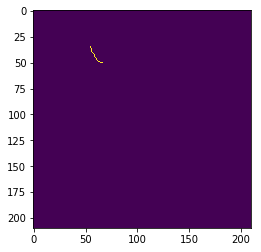

In [171]:
plt.imshow(zeros)

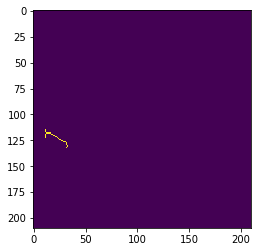

In [47]:
plt.imshow(zeros2)

# Tortousity

In [18]:
import math
import numpy as np

def _distance_2p(x1, y1, x2, y2):
    """
    calculates the distance between two given points
    :param x1: starting x value
    :param y1: starting y value
    :param x2: ending x value
    :param y2: ending y value
    :return: the distance between [x1, y1] -> [x2, y2]
    """
    return ((x2 - x1) ** 2 + (y2 - y1) ** 2) ** 0.5


def _curve_length(x, y):
    """
    calculates the length(distance) of the given curve, iterating from point to point.
    :param x: the x component of the curve
    :param y: the y component of the curve
    :return: the curve length
    """
    distance = 0
    for i in range(0, len(x) - 1):
        distance += _distance_2p(x[i], y[i], x[i + 1], y[i + 1])
    return distance


def _chord_length(x, y):
    """
    distance between starting and end point of the given curve
    :param x: the x component of the curve
    :param y: the y component of the curve
    :return: the chord length of the given curve
    """
    return _distance_2p(x[0], y[0], x[len(x) - 1], y[len(y) - 1])


def _detect_inflection_points(x, y):
    """
    This method detects the inflection points of a given curve y=f(x) by applying a convolution to
    the y values and checking for changes in the sign of this convolution, each sign change is
    interpreted as an inflection point.
    It will ignore the first and last 2 pixels.
    :param x: the x values of the curve
    :param y: the y values of the curve
    :return: the array position in x of the inflection points.
    """
    cf = np.convolve(y, [1, -1])
    inflection_points = []
    for iterator in range(2, len(x)):
        if np.sign(cf[iterator]) != np.sign(cf[iterator - 1]):
            inflection_points.append(iterator - 1)
    return inflection_points


def distance_measure_tortuosity(contour):
    """
    Distance measure tortuosity defined in:
    William E Hart, Michael Goldbaum, Brad Côté, Paul Kube, and Mark R Nelson. Measurement and
    classification of retinal vascular tortuosity. International journal of medical informatics,
    53(2):239–252, 1999.
    :param x: the list of x points of the curve
    :param y: the list of y points of the curve
    :return: the arc-chord tortuosity measure
    """
    x = list()
    y = list()
    print(contour)
    print(contour[0])
    for pixel in contour:
        x.append(pixel[1])
        y.append(pixel[0])
    if len(x) < 2:
        raise ValueError("Given curve must have at least 2 elements")

    return _curve_length(x, y) / _chord_length(x, y)


def distance_inflection_count_tortuosity(contour):
    """
    Calculates the tortuosity by using arc-chord ratio multiplied by the curve inflection count
    plus 1
    :param x: the list of x points of the curve
    :param y: the list of y points of the curve
    :return: the inflection count tortuosity
    """
    x = list()
    y = list()
    print(contour)
    print(contour[0])
    for pixel in contour:
        x.append(pixel[1])
        y.append(pixel[0])

    return distance_measure_tortuosity(contour) * (len(_detect_inflection_points(x, y)) + 1)

In [19]:
uni10 = contours[10]

In [20]:
uni10 = get_unique(uni10)

In [28]:
distance_measure_tortuosity(uni10[0])

[[15, 198], [15, 199], [152, 100], [152, 101], [152, 102], [152, 103], [152, 104], [152, 105], [152, 106], [151, 107], [151, 108], [150, 109], [150, 110], [149, 111], [149, 112], [148, 113]]
[15, 198]


1.1700551105537558

In [33]:
distance_inflection_count_tortuosity(uni10[0])

[[15, 198], [15, 199], [152, 100], [152, 101], [152, 102], [152, 103], [152, 104], [152, 105], [152, 106], [151, 107], [151, 108], [150, 109], [150, 110], [149, 111], [149, 112], [148, 113]]
[15, 198]
[[15, 198], [15, 199], [152, 100], [152, 101], [152, 102], [152, 103], [152, 104], [152, 105], [152, 106], [151, 107], [151, 108], [150, 109], [150, 110], [149, 111], [149, 112], [148, 113]]
[15, 198]


11.700551105537558